In [1]:
import cv2
from brukerapi.dataset import Dataset as ds
import numpy as np
import matplotlib.pyplot as plt
import glob
import scipy.optimize as op
import time
from tqdm.notebook import tqdm

In [2]:
folders = ["230-249", "251-270", "272-291", "292-312", "314-333", "335-354", "356-375", "377-396","398-417", "419-438", "440-459", "461-480"]
rois = np.genfromtxt("ROIset.txt", delimiter=",", dtype=np.int)
f1roi, f2roi, wroi = rois

valsTensor = []
xMat = []
GMat = []
dMat = []
DMat = []
TMat = []
NMat = []

for folder, i in zip(folders, tqdm(range(len(folders)), leave=False)):
    im_paths = sorted(glob.glob("../data/" + folder + "/*/pdata/1/2dseq"))
    method_paths = sorted(glob.glob("../data/" + folder + "/*/method"))

    f1_val = []
    f2_val = [] 
    w_val = []

    x_val = []
    d_val = []
    D_val = []
    G_val = []
    T_val = []
    N_val = []
    
    for im_path, method_path in zip(im_paths,method_paths):

        dataset = ds(im_path)
        data = np.array(dataset.data)
        
        f1_val.append(np.mean(data[f1roi[1]:f1roi[1]+f1roi[3],f1roi[0]:f1roi[0]+f1roi[2],0,1]))
        f2_val.append(np.mean(data[f2roi[1]:f2roi[1]+f2roi[3],f2roi[0]:f2roi[0]+f2roi[2],0,1]))
        w_val.append(np.mean(data[wroi[1]:wroi[1]+wroi[3],wroi[0]:wroi[0]+wroi[2],0,1]))

        mth = open(method_path)
        mth = mth.read().split("##")

        G_val.append(float([i for i in mth if i.startswith('$RampGradStr')][0].split("\n")[0][13:]))
        x_val.append(float([i for i in mth if i.startswith('$RampGradX')][0].split("\n")[0][11:]))
        d_val.append(float([i for i in mth if i.startswith('$PVM_DwGradDur')][0].split("\n")[1]))
        D_val.append(float([i for i in mth if i.startswith('$PVM_DwGradSep')][0].split("\n")[1]))
        T_val.append(float([i for i in mth if i.startswith('$Tnogse')][0].split("\n")[0][8:]))
        N_val.append(float([i for i in mth if i.startswith('$RampGradN')][0].split("\n")[0][11:]))

    valsTensor.append([f1_val, f2_val, w_val])
    xMat.append(x_val)
    dMat.append(d_val)
    DMat.append(D_val)
    GMat.append(G_val)
    TMat.append(T_val)
    NMat.append(N_val)

  0%|          | 0/12 [00:00<?, ?it/s]

In [42]:
# plotea rampa en x

for folder, it in zip(folders[0:4], range(4)):
    plt.plot(xMat[it], valsTensor[it][0], "-o", label="f1")
    plt.plot(xMat[it], valsTensor[it][1], "-o", label="f2")
    plt.plot(xMat[it], valsTensor[it][2], "-o", label="agua")

    plt.grid()
    plt.xlabel("$x$ [ms]")
    plt.ylabel("$M$")
    plt.legend()

    plt.savefig("../plots/NOGSE/" + folder + ".pdf")
    plt.show()

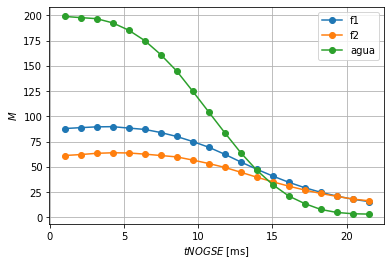

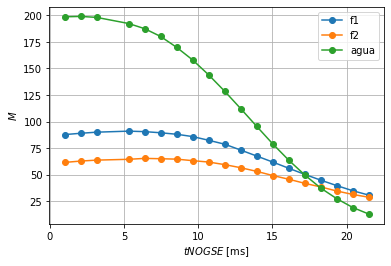

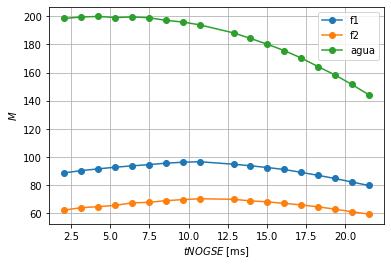

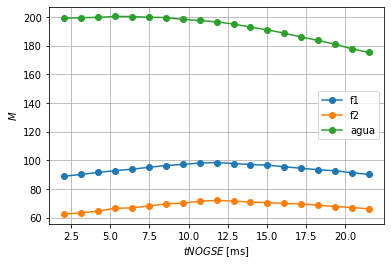

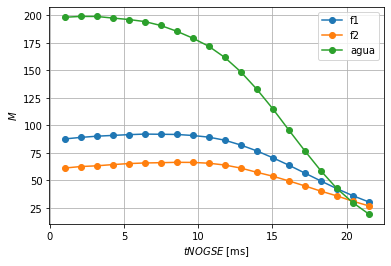

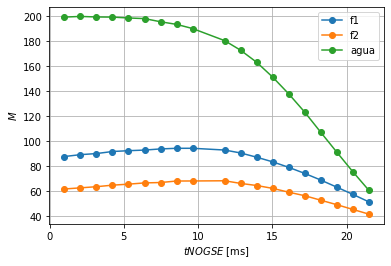

In [10]:
# plotea rampa en t

for folder, it in zip(folders[4:10], range(4,10)):
    plt.plot(TMat[it], valsTensor[it][0], "-o", label="f1")
    plt.plot(TMat[it], valsTensor[it][1], "-o", label="f2")
    plt.plot(TMat[it], valsTensor[it][2], "-o", label="agua")

    plt.grid()
    plt.xlabel("$t NOGSE$ [ms]")
    plt.ylabel("$M$")
    plt.legend()

    plt.savefig("../plots/NOGSE/" + folder + ".pdf")
    plt.show()

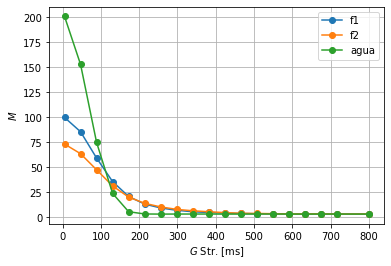

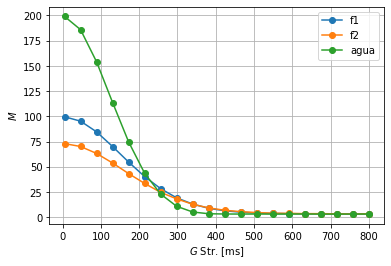

In [37]:
# plotea rampa en G

for folder, it in zip(folders[10:12], range(10,12)):
    plt.plot(GMat[it], valsTensor[it][0], "-o", label="f1")
    plt.plot(GMat[it], valsTensor[it][1], "-o", label="f2")
    plt.plot(GMat[it], valsTensor[it][2], "-o", label="agua")

    plt.grid()
    plt.xlabel("$G$ Str. [ms]")
    plt.ylabel("$M$")
    plt.legend()

    plt.savefig("../plots/NOGSE/" + folder + ".pdf")
    plt.show()

In [97]:
# MODELO PARA DIFUSIÓN LIBRE - PAPER GONZALO 2014.

def MDiffFree(X, D0, M0):
    x, N, TE, G = X
    g = 267.52218744 # ms**-1 mT**-1

    x = np.array(x)
    N = np.array(N)
    TE = np.array(TE)
    G = np.array(G)

    y = TE - (N-1)*x

    return M0*np.exp(- g**2 * G**2/12 * D0 * ((N-1)*x**3 + y**3))

In [131]:
# OBTENGO COEFICIENTE DE DIFUSION LIBRE PARA EL AGUA EN LAS MEDIDAS (0,3)

params0,var0= op.curve_fit(MDiffFree, [xMat[0], NMat[0], TMat[0], GMat[0]], valsTensor[0][2], p0=[0.000000000001,50])
params1,_ = op.curve_fit(MDiffFree, [xMat[1], NMat[1], TMat[1], GMat[1]], valsTensor[1][2], p0=[0.000000000001,50])
params2,_ = op.curve_fit(MDiffFree, [xMat[2], NMat[2], TMat[2], GMat[2]], valsTensor[2][2], p0=[0.000000000001,50])
params3,_ = op.curve_fit(MDiffFree, [xMat[3], NMat[3], TMat[3], GMat[3]], valsTensor[3][2], p0=[0.000000000001,50])

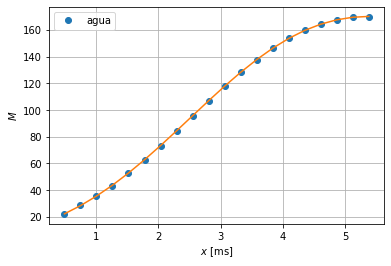

In [132]:
fig, ax0 = plt.subplots()

ax0.plot(xMat[2], valsTensor[2][2], "o", label="agua")
ax0.plot(xMat[2], MDiffFree([xMat[2], NMat[2], TMat[2], GMat[2]], params2[0],params2[1]))

ax0.set_xlabel("$x$ [ms]")
ax0.set_ylabel("$M$")

plt.legend()

plt.grid()

In [124]:
print("Serie 1 -> D0 = ", params0[0])
print("Serie 2 -> D0 = ", params1[0])
print("Serie 3 -> D0 = ", params2[0])
print("Serie 4 -> D0 = ", params3[0])

Serie 1 -> D0 =  2.2424375143739826e-12
Serie 2 -> D0 =  2.2217101429613775e-12
Serie 3 -> D0 =  2.269866279955162e-12
Serie 4 -> D0 =  2.2583222814508477e-12


Serie 1 -> D0 =  9.586525292223156e-13
Serie 2 -> D0 =  7.481110300348696e-13
Serie 3 -> D0 =  1.1190035383729458e-12
Serie 4 -> D0 =  1.0047115474456808e-12


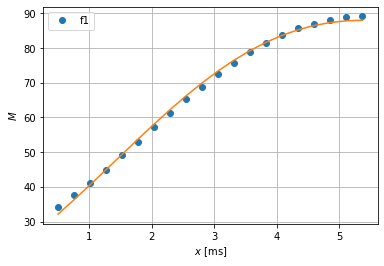

In [129]:
# OBTENGO COEFICIENTE DE DIFUSION LIBRE PARA LA FIBRA 1 EN LAS MEDIDAS (0,3)

params0,var0= op.curve_fit(MDiffFree, [xMat[0], NMat[0], TMat[0], GMat[0]], valsTensor[0][0], p0=[0.000000000001,50])
params1,_ = op.curve_fit(MDiffFree, [xMat[1], NMat[1], TMat[1], GMat[1]], valsTensor[1][0], p0=[0.000000000001,50])
params2,_ = op.curve_fit(MDiffFree, [xMat[2], NMat[2], TMat[2], GMat[2]], valsTensor[2][0], p0=[0.000000000001,50])
params3,_ = op.curve_fit(MDiffFree, [xMat[3], NMat[3], TMat[3], GMat[3]], valsTensor[3][0], p0=[0.000000000001,50])

print("Serie 1 -> D0 = ", params0[0])
print("Serie 2 -> D0 = ", params1[0])
print("Serie 3 -> D0 = ", params2[0])
print("Serie 4 -> D0 = ", params3[0])

fig, ax0 = plt.subplots()

ax0.plot(xMat[2], valsTensor[2][0], "o", label="f1")
ax0.plot(xMat[2], MDiffFree([xMat[2], NMat[2], TMat[2], GMat[2]], params2[0],params2[1]))

ax0.set_xlabel("$x$ [ms]")
ax0.set_ylabel("$M$")

plt.legend()

plt.grid()

Serie 1 -> D0 =  7.504599792964203e-13
Serie 2 -> D0 =  5.754229499118521e-13
Serie 3 -> D0 =  9.061272844129636e-13
Serie 4 -> D0 =  7.975223702072789e-13


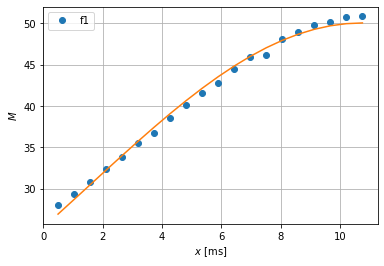

In [134]:
# OBTENGO COEFICIENTE DE DIFUSION LIBRE PARA LA FIBRA 2 EN LAS MEDIDAS (0,3)

params0,var0= op.curve_fit(MDiffFree, [xMat[0], NMat[0], TMat[0], GMat[0]], valsTensor[0][1], p0=[0.000000000001,50])
params1,_ = op.curve_fit(MDiffFree, [xMat[1], NMat[1], TMat[1], GMat[1]], valsTensor[1][1], p0=[0.000000000001,50])
params2,_ = op.curve_fit(MDiffFree, [xMat[2], NMat[2], TMat[2], GMat[2]], valsTensor[2][1], p0=[0.000000000001,50])
params3,_ = op.curve_fit(MDiffFree, [xMat[3], NMat[3], TMat[3], GMat[3]], valsTensor[3][1], p0=[0.000000000001,50])

print("Serie 1 -> D0 = ", params0[0])
print("Serie 2 -> D0 = ", params1[0])
print("Serie 3 -> D0 = ", params2[0])
print("Serie 4 -> D0 = ", params3[0])

fig, ax0 = plt.subplots()

ax0.plot(xMat[0], valsTensor[0][1], "o", label="f1")
ax0.plot(xMat[0], MDiffFree([xMat[0], NMat[0], TMat[0], GMat[0]], params0[0],params0[1]))

ax0.set_xlabel("$x$ [ms]")
ax0.set_ylabel("$M$")

plt.legend()

plt.grid()

In [4]:
# MODELO PARA DIFUSIÓN CON RESTRICCIONES CPMG- 2015-JMR-SHEMESH-ETA

def MCPMG(X, tc, M0):
    TN, N, G = X
    g = 267.52218744 # ms**-1 mT**-1

    TN = np.array(TN)
    N = np.array(N)
    G = np.array(G)

    A = (2*N + 1) - (-1)**N * np.exp(- TN/tc)
    B = (-4/(np.exp(-TN/(N*tc)) + 1)**2) * ((-1)**(N+1)*np.exp(-TN/(tc))*(np.exp(-3*TN/(2*N*tc)) + np.exp(-TN/(2*N*tc)) - np.exp(-TN/(N*tc))) + np.exp(-3*TN/(2*N*tc)) + np.exp(-TN/(2*N*tc)) + N*np.exp(-2*TN/(N*tc)) + (N-1)*np.exp(-TN/(N*tc)))

    return M0*np.exp(-g**2 * G**2 * D0 * tc**2 * (TN - tc*(A+B)))  

In [6]:
# MODELO PARA DIFUSIÓN CON RESTRICCIONES NOGSE

def MNOGSE(X, tauc, M0, D=2.3*10**-12):
    x, TE, N, G = X
    g = 267.52218744 # ms**-1 mT**-1

    x = np.array(x)
    TE = np.array(TE)
    N = np.array(N)
    G = np.array(G)

    y = TE - (N-1) * x

    bSE=g*G*np.sqrt(D*tauc)
 
    return M0 * np.exp(-bSE ** 2 * tauc ** 2 * (4 * np.exp(-y / tauc / 2) - np.exp(-y / tauc) - 3 + y / tauc)) * np.exp(-bSE ** 2 * tauc ** 2 * ((N - 1) * x / tauc + (-1) ** (N - 1) * np.exp(-(N - 1) * x / tauc) + 1 - 2 * N - 4 * np.exp(-(N - 1) * x / tauc) ** (1 / (N - 1) / 2) * (-np.exp(-(N - 1) * x / tauc) ** (1 / (N - 1))) ** (N - 1) / (np.exp(-(N - 1) * x / tauc) ** (1 / (N - 1)) + 1) + 4 * np.exp(-(N - 1) * x / tauc) ** (1 / (N - 1) / 2) / (np.exp(-(N - 1) * x / tauc) ** (1 / (N - 1)) + 1) + 4 * (-np.exp(-(N - 1) * x / tauc) ** (1 / (N - 1))) ** (N - 1) * np.exp(-(N - 1) * x / tauc) ** (1 / (N - 1)) / (np.exp(-(N - 1) * x / tauc) ** (1 / (N - 1)) + 1) ** 2 + 4 * np.exp(-(N - 1) * x / tauc) ** (1 / (N - 1)) * ((N - 1) * np.exp(-(N - 1) * x / tauc) ** (1 / (N - 1)) + N - 2) / (np.exp(-(N - 1) * x / tauc) ** (1 / (N - 1)) + 1) ** 2)) * np.exp(2 * tauc ** 2 * ((np.exp((-y + 2 * x) / tauc / 2) + np.exp((x - 2 * y) / tauc / 2) - np.exp((x - y) / tauc) / 2 - np.exp(-y / tauc) / 2 + np.exp(x / tauc / 2) + np.exp(-y / tauc / 2) - np.exp(x / tauc) / 2 - 0.1e1 / 0.2e1) * (-1) ** (2 * N) + 2 * (-1) ** (1 + N) * np.exp(-(2 * N * x - 3 * x + y) / tauc / 2) + (np.exp(((3 - 2 * N) * x - 2 * y) / tauc / 2) - np.exp((-N * x + 2 * x - y) / tauc) / 2 + np.exp(-(2 * N * x - 4 * x + y) / tauc / 2) + np.exp(-(2 * N * x - 2 * x + y) / tauc / 2) - np.exp((-N * x + x - y) / tauc) / 2 + np.exp(-x * (-3 + 2 * N) / tauc / 2) - np.exp(-x * (N - 2) / tauc) / 2 - np.exp(-(N - 1) * x / tauc) / 2) * (-1) ** N + 2 * (-1) ** (1 + 2 * N) * np.exp((x - y) / tauc / 2)) * bSE ** 2 / (np.exp(x / tauc) + 1))

Serie 1, f1 -> lc =  7.322142084097539e-06  +-  1.1816833795422406e-06
Serie 2, f1 -> lc =  6.417694710411973e-06  +-  1.0203083477087636e-06
Serie 3, f1 -> lc =  6.747229342396121e-06  +-  9.736260681067103e-07
Serie 4, f1 -> lc =  6.154384164247991e-06  +-  8.052749395155088e-07


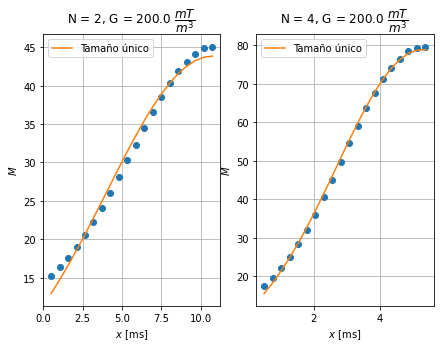

In [35]:
# FITTING NOGSE UN SOLO TAMAÑO

start = 0
end = 4

params0f1,cov0f1= op.curve_fit(MNOGSE, [xMat[0], TMat[0], NMat[0], GMat[0]], valsTensor[0][0], p0=[10, 100], absolute_sigma=True)
params1f1,cov1f1= op.curve_fit(MNOGSE, [xMat[1], TMat[1], NMat[1], GMat[1]], valsTensor[1][0], p0=[10, 100], absolute_sigma=True)
params2f1,cov2f1= op.curve_fit(MNOGSE, [xMat[2], TMat[2], NMat[2], GMat[2]], valsTensor[2][0], p0=[10, 100], absolute_sigma=True)
params3f1,cov3f1= op.curve_fit(MNOGSE, [xMat[3], TMat[3], NMat[3], GMat[3]], valsTensor[3][0], p0=[10, 100], absolute_sigma=True)
D0 = 2.3*10**-12

err0 = np.sqrt(np.diag(cov0f1))
err1 = np.sqrt(np.diag(cov1f1))
err2 = np.sqrt(np.diag(cov2f1))
err3 = np.sqrt(np.diag(cov3f1))

print("Serie 1, f1 -> lc = ", np.sqrt(2*D0*params0f1[0]), " +- ", np.sqrt(2*D0*err0[0]))
print("Serie 2, f1 -> lc = ", np.sqrt(2*D0*params1f1[0]), " +- ", np.sqrt(2*D0*err1[0]))
print("Serie 3, f1 -> lc = ", np.sqrt(2*D0*params2f1[0]), " +- ", np.sqrt(2*D0*err2[0]))
print("Serie 4, f1 -> lc = ", np.sqrt(2*D0*params3f1[0]), " +- ", np.sqrt(2*D0*err3[0]))

params = [params0f1, params1f1, params2f1, params3f1]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7,5))

ax1.plot(xMat[start+1], valsTensor[start+1][0], "o")
ax1.plot(xMat[start+1], MNOGSE([xMat[start+1],TMat[start+1], NMat[start+1], GMat[start+1]], params[1][0], params[1][1]), label="Tamaño único")

ax1.set_xlabel("$x$ [ms]")
ax1.set_ylabel("$M$")

ax1.grid()
ax1.set_title("N = " + str(int(NMat[start+1][0])) + ", G = " + str(GMat[start+1][0]) + " $\dfrac{mT}{m^3}$")

ax1.legend()


ax2.plot(xMat[start+3], valsTensor[start+3][0], "o")
ax2.plot(xMat[start+3], MNOGSE([xMat[start+3],TMat[start+3], NMat[start+3], GMat[start+3]], params[3][0], params[3][1]), label="Tamaño único")

ax2.set_xlabel("$x$ [ms]")
ax2.set_ylabel("$M$")

ax2.grid()
ax2.set_title("N = " + str(int(NMat[start+3][0])) + ", G = " + str(GMat[start+3][0]) + " $\dfrac{mT}{m^3}$")

ax2.legend()


plt.savefig("../plots/NOGSEfits/TODAS_lc_unico_f1.pdf", bbox_inches="tight")
plt.show()

In [26]:
params0f2,cov0f2= op.curve_fit(MNOGSE, [xMat[0], TMat[0], NMat[0], GMat[0]], valsTensor[0][1], p0=[10, 100], absolute_sigma=True)
params1f2,cov1f2= op.curve_fit(MNOGSE, [xMat[1], TMat[1], NMat[1], GMat[1]], valsTensor[1][1], p0=[10, 100], absolute_sigma=True)
params2f2,cov2f2= op.curve_fit(MNOGSE, [xMat[2], TMat[2], NMat[2], GMat[2]], valsTensor[2][1], p0=[10, 100], absolute_sigma=True)
params3f2,cov3f2= op.curve_fit(MNOGSE, [xMat[3], TMat[3], NMat[3], GMat[3]], valsTensor[3][1], p0=[10, 100], absolute_sigma=True)
D0 = 2.3*10**-12

err0 = np.sqrt(np.diag(cov0f2))
err1 = np.sqrt(np.diag(cov1f2))
err2 = np.sqrt(np.diag(cov2f2))
err3 = np.sqrt(np.diag(cov3f2))

print("Serie 1, f2 -> lc = ", np.sqrt(2*D0*params0f2[0]), " +- ", np.sqrt(2*D0*err0[0]))
print("Serie 2, f2 -> lc = ", np.sqrt(2*D0*params1f2[0]), " +- ", np.sqrt(2*D0*err1[0]))
print("Serie 3, f2 -> lc = ", np.sqrt(2*D0*params2f2[0]), " +- ", np.sqrt(2*D0*err2[0]))
print("Serie 4, f2 -> lc = ", np.sqrt(2*D0*params3f2[0]), " +- ", np.sqrt(2*D0*err3[0]))

Serie 1, f2 -> lc =  6.418011138803586e-06  +-  1.1343741119875645e-06
Serie 2, f2 -> lc =  5.722525110889545e-06  +-  9.666912556342478e-07
Serie 3, f2 -> lc =  5.913284776693452e-06  +-  9.276383015264495e-07
Serie 4, f2 -> lc =  5.452378158663719e-06  +-  7.556983967953198e-07


Serie 1, f2 -> Tc =  9.353028273162629
Serie 2, f2 -> Tc =  7.377806823324366
Serie 3, f2 -> Tc =  8.008751535913703
Serie 4, f2 -> Tc =  6.764264175714354


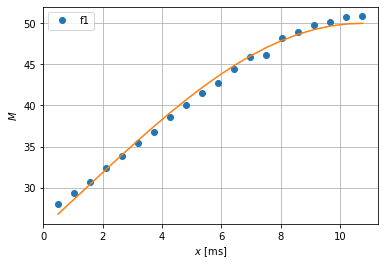

In [222]:
params0f2,_= op.curve_fit(MNOGSE, [xMat[0], TMat[0], NMat[0], GMat[0]], valsTensor[0][1], p0=[10, 100])
params1f2,_= op.curve_fit(MNOGSE, [xMat[1], TMat[1], NMat[1], GMat[1]], valsTensor[1][1], p0=[10, 100])
params2f2,_= op.curve_fit(MNOGSE, [xMat[2], TMat[2], NMat[2], GMat[2]], valsTensor[2][1], p0=[10, 100])
params3f2,_= op.curve_fit(MNOGSE, [xMat[3], TMat[3], NMat[3], GMat[3]], valsTensor[3][1], p0=[10, 100])

print("Serie 1, f2 -> Tc = ", params0f2[0])
print("Serie 2, f2 -> Tc = ", params1f2[0])
print("Serie 3, f2 -> Tc = ", params2f2[0])
print("Serie 4, f2 -> Tc = ", params3f2[0])

fig, ax0 = plt.subplots()

ax0.plot(xMat[0], valsTensor[0][1], "o", label="f1")
ax0.plot(xMat[0], MNOGSE([xMat[0],TMat[0], NMat[0], GMat[0]], params0[0], params0[1]))

ax0.set_xlabel("$x$ [ms]")
ax0.set_ylabel("$M$")

plt.legend()

plt.grid()

In [11]:
# AHORA VAMOS CON DISTRIBUCIÓN DE TAMAÑOS

def lognormal(lc, sigma, lcmid):
    return 1/(lc*sigma*np.sqrt(2*np.pi)) * np.exp(-(np.log(lc)-np.log(lcmid))**2/(2*sigma**2))

def MNOGSEdist(X, M0, sigma, lcmid, D=2.3*10**-12):
    #sigma = 0.06416131084794455
    #lcmid = 7.3*10**-6

    x,_,_,_ = X
    n = 100
    sum = 0
    lmax = 40 * 10**-6

    lcs = np.linspace(5*10**-7, lmax, n)
    weights = lognormal(lcs, sigma, lcmid)
    weights = weights/np.sum(weights)

    out = np.zeros(len(x))

    for lc, w in zip(lcs, weights):
        tauc = lc**2/(2*D)
        out = out + MNOGSE(X, tauc, M0, D)*w

    return out

Serie 1, f1 -> lcmid =  1.0279255041436713e-05 +- 2.8983402498834054e-06
               sigma =  0.7665662775238995 +- 0.3418919403598912

Serie 2, f1 -> lcmid =  9.140932544913481e-06 +- 1.1423682579497238e-06
               sigma =  0.592744386673011 +- 0.1304509047004617
/home/said/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
Serie 3, f1 -> lcmid =  6.925513547123546e-06 +-
               sigma =  0.0005451798829120107 +-
Serie 4, f1 -> lcmid =  6.981779050530858e-06 +- 3.242727269896921e-07
               sigma =  0.37959841728597055 +- 0.08088553384037568


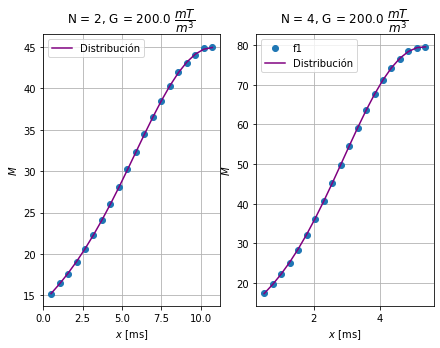

In [42]:
# FIBRA 1

start = 0
end = 4

params0f1, cov0f1= op.curve_fit(MNOGSEdist, [xMat[0], TMat[0], NMat[0], GMat[0]], valsTensor[0][0], p0=[100, 0.6416131084794455, 7.3*10**-6], absolute_sigma=True)
err = np.sqrt(np.diag(cov0f1))
print("Serie 1, f1 -> lcmid = ", params0f1[2], "+-", err[2])
print("               sigma = ", params0f1[1], "+-", err[1])
print()

params1f1, cov1f1= op.curve_fit(MNOGSEdist, [xMat[1], TMat[1], NMat[1], GMat[1]], valsTensor[1][0], p0=[100, 0.6416131084794455, 7.3*10**-6], absolute_sigma=True)
err = np.sqrt(np.diag(cov1f1))
print("Serie 2, f1 -> lcmid = ", params1f1[2], "+-", err[2])
print("               sigma = ", params1f1[1], "+-", err[1])

params2f1, cov2f2= op.curve_fit(MNOGSEdist, [xMat[2], TMat[2], NMat[2], GMat[2]], valsTensor[2][0], p0=[100, 0.6416131084794455, 7.3*10**-6], absolute_sigma=True)
err = np.sqrt(np.diag(cov2f1))
try:
    print("Serie 3, f1 -> lcmid = ", params2f1[2], "+-", err[2])
    print("               sigma = ", params2f1[1], "+-", err[1])
except:
    print("Serie 3, f1 -> lcmid = ", params2f1[2], "+-")
    print("               sigma = ", params2f1[1], "+-")

params3f1, cov3f1= op.curve_fit(MNOGSEdist, [xMat[3], TMat[3], NMat[3], GMat[3]], valsTensor[3][0], p0=[100, 0.6416131084794455, 7.3*10**-6], absolute_sigma=True)
err = np.sqrt(np.diag(cov3f1))
print("Serie 4, f1 -> lcmid = ", params3f1[2], "+-", err[2])
print("               sigma = ", params3f1[1], "+-", err[1])

params = [params0f1, params1f1, params2f1, params3f1]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(7,5))

ax1.plot(xMat[start+1], valsTensor[start+1][0], "o")
ax1.plot(xMat[start+1], MNOGSEdist([xMat[start+1],TMat[start+1], NMat[start+1], GMat[start+1]], params[start+1][0], params[start+1][1], params[start+1][2]), label="Distribución", c="purple")

ax1.set_xlabel("$x$ [ms]")
ax1.set_ylabel("$M$")

ax1.grid()
ax1.set_title("N = " + str(int(NMat[start+1][0])) + ", G = " + str(GMat[start+1][0]) + " $\dfrac{mT}{m^3}$")

ax1.legend()

ax2.plot(xMat[start+3], valsTensor[start+3][0], "o")
ax2.plot(xMat[start+3], MNOGSEdist([xMat[start+3],TMat[start+3], NMat[start+3], GMat[start+3]], params[start+3][0], params[start+3][1], params[start+3][2]), label="Distribución", c="purple")

ax2.set_xlabel("$x$ [ms]")
ax2.set_ylabel("$M$")

ax2.grid()
ax2.set_title("N = " + str(int(NMat[start+3][0])) + ", G = " + str(GMat[start+3][0]) + " $\dfrac{mT}{m^3}$")

ax2.legend()

plt.savefig("../plots/NOGSEfits/TODAS_lc_lognormal_f1.pdf", bbox_inches="tight")
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


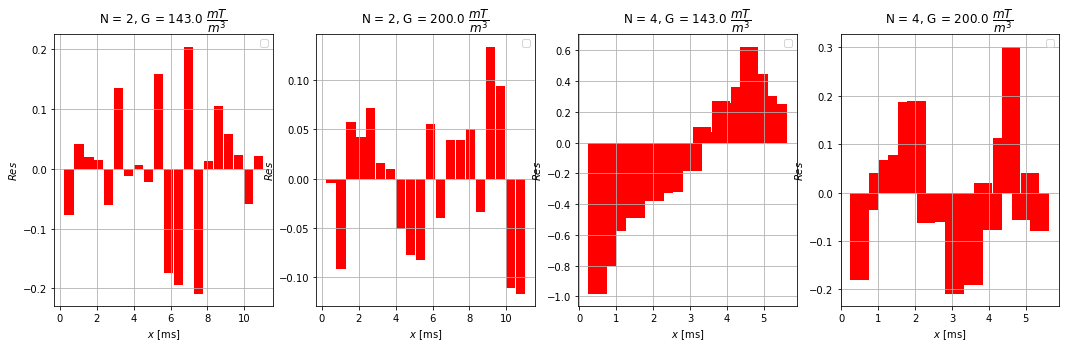

In [36]:
# PLOTEO RESIDUOS DE AJUSTES

fig, axs = plt.subplots(1,4, figsize=(18,5))

for it, name, param, ax, N, G in zip(range(start,end), folders[start:end], params[start:end], axs, NMat, GMat):

    res = MNOGSEdist([xMat[it],TMat[it], NMat[it], GMat[it]], param[0], param[1], param[2]) - valsTensor[it][0]

    ax.bar(xMat[it], res, color="red", width=0.5)

    ax.set_xlabel("$x$ [ms]")
    ax.set_ylabel("$Res$")

    ax.grid()
    ax.set_title("N = " + str(int(N[0])) + ", G = " + str(G[0]) + " $\dfrac{mT}{m^3}$")
    
    ax.legend()
plt.savefig("../plots/NOGSEfits/res_lc_lognormal_f1.pdf", bbox_inches="tight")
plt.show()

Serie 1, f2 -> lcmid =  8.767374415186286e-06 +- 3.308165753628618e-06
               sigma =  0.880142182794919 +- 0.5575827361174553

Serie 2, f2 -> lcmid =  7.56545588190047e-06 +- 9.133280276918912e-07
               sigma =  0.5591982249466253 +- 0.15730085021080342
Serie 3, f2 -> lcmid =  6.0100328025876234e-06 +- 4.633709515589782e-07
               sigma =  0.17185097847899897 +- 0.4307608944228696
Serie 4, f2 -> lcmid =  5.899765497334208e-06 +- 2.605812041149099e-07
               sigma =  0.3231413038322298 +- 0.10384508018110711


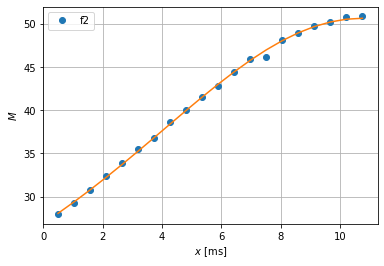

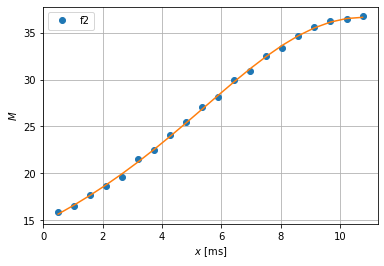

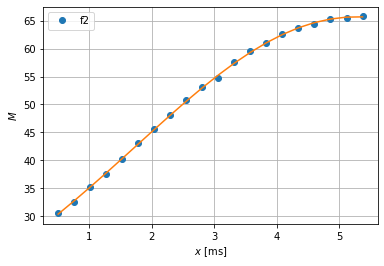

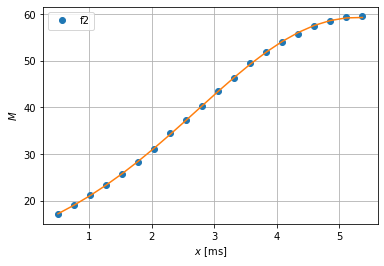

In [25]:
# FIBRA 2

start = 0
end = 4

params0f2, cov0f2= op.curve_fit(MNOGSEdist, [xMat[0], TMat[0], NMat[0], GMat[0]], valsTensor[0][1], p0=[100, 0.6416131084794455, 7.3*10**-6], absolute_sigma=True)
err = np.sqrt(np.diag(cov0f2))
print("Serie 1, f2 -> lcmid = ", params0f2[2], "+-", err[2])
print("               sigma = ", params0f2[1], "+-", err[1])
print()

params1f2, cov1f2= op.curve_fit(MNOGSEdist, [xMat[1], TMat[1], NMat[1], GMat[1]], valsTensor[1][1], p0=[100, 0.6416131084794455, 7.3*10**-6], absolute_sigma=True)
err = np.sqrt(np.diag(cov1f2))
print("Serie 2, f2 -> lcmid = ", params1f2[2], "+-", err[2])
print("               sigma = ", params1f2[1], "+-", err[1])

params2f2, cov2f2= op.curve_fit(MNOGSEdist, [xMat[2], TMat[2], NMat[2], GMat[2]], valsTensor[2][1], p0=[100, 0.6416131084794455, 7.3*10**-6], absolute_sigma=True)
err = np.sqrt(np.diag(cov2f2))
try:
    print("Serie 3, f2 -> lcmid = ", params2f2[2], "+-", err[2])
    print("               sigma = ", params2f2[1], "+-", err[1])
except:
    print("Serie 3, f2 -> lcmid = ", params2f2[2], "+-")
    print("               sigma = ", params2f2[1], "+-")

params3f2, cov3f2= op.curve_fit(MNOGSEdist, [xMat[3], TMat[3], NMat[3], GMat[3]], valsTensor[3][1], p0=[100, 0.6416131084794455, 7.3*10**-6], absolute_sigma=True)
err = np.sqrt(np.diag(cov3f2))
print("Serie 4, f2 -> lcmid = ", params3f2[2], "+-", err[2])
print("               sigma = ", params3f2[1], "+-", err[1])

params = [params0f2, params1f2, params2f2, params3f2]

for it, name, param in zip(range(start,end), folders[start:end], params[start:end]):
    fig, ax0 = plt.subplots()

    ax0.plot(xMat[it], valsTensor[it][1], "o", label="f2")
    ax0.plot(xMat[it], MNOGSEdist([xMat[it],TMat[it], NMat[it], GMat[it]], param[0], param[1], param[2]))

    ax0.set_xlabel("$x$ [ms]")
    ax0.set_ylabel("$M$")

    plt.legend()

    plt.grid()

    plt.savefig("../plots/NOGSEfits/" + name + "_lognormalf2.png")
    plt.show()

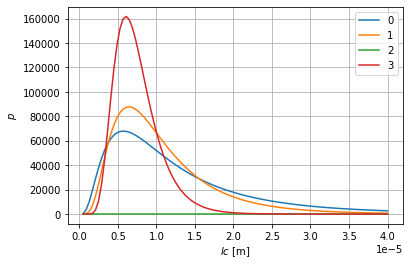

In [26]:
fig, ax0 = plt.subplots()

for it, name, param in zip(range(start,4), folders[start:end], params[start:end]):
    n = 100
    lmax = 40 * 10**-6
    lcs = np.linspace(5*10**-7, lmax, n)
    ax0.plot(lcs, lognormal(lcs, param[1], param[2]), label=it)

ax0.set_xlabel("$lc$ [m]")
ax0.set_ylabel("$p$")

plt.legend()
plt.grid()

plt.savefig("../plots/NOGSEfits/" + name + "_sizedistf1.pdf")

plt.show()

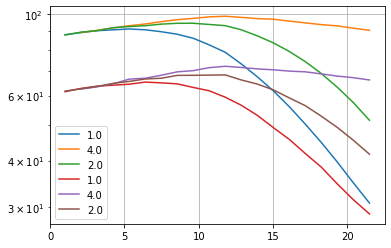

In [40]:
# AHORA VAMOS CON LAS MEDIDAS EN FUNCION DE TNOGSE

start = 4
end = 10

# PLOTEO PARA CADA FIBRA LA MAGNETIZACION EN FUNCION DEL GRADIENTE PARA DIFERENTES N

fig, ax = plt.subplots()
plt.grid()
der

for serie, name in zip(np.arange(start+1,end,2), folders[start:end:2]): 
    ax.plot(TMat[serie], valsTensor[serie][0], label=NMat[serie][0])

for serie, name in zip(np.arange(start+1,end,2), folders[start:end:2]): 
    ax.plot(TMat[serie], valsTensor[serie][1], label=NMat[serie][0])
plt.legend()

plt.yscale("log")
plt.show()

# VER SI HACER ANALISIS CUALITATIVO O AJUSTAR TIRANDO LA PRIMER PARTE QUE TIENE MUCHO ERROR. LA COLA ES DESCRIPTA POR LA ECUACION
# S.17

In [155]:
def MDecCPMG(TE, lc, N, G, D0):
    g = 267.52218744 # ms**-1 mT**-1
    tc = (lc**2)/(2*D0)
    Dw2 = g**2 * G**2 * D0 * tc

    return np.exp(-Dw2 * tc * (TE-(1+2*N)*tc))

def MDecCPMGdist(X, M0, sigma, lcmid):
    TE, N, G = X
    D0 = 2.3*10**-12
    n = 100
    lmax = 30 * 10**-6
    lcs = np.linspace(5*10**-7, lmax, n)

    weights = lognormal(lcs, sigma, lcmid)
    weights = weights/np.sum(weights)

    out = np.zeros(len(TE))

    for lc, w in zip(lcs, weights):
            out = out + MDecCPMG(TE, lc, N, G, D0)*w

    return out

<ipython-input-155-d90831a09275>:6: RuntimeWarning: overflow encountered in exp
  return np.exp(-Dw2 * tc * (TE-(1+2*N)*tc))
/home/said/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


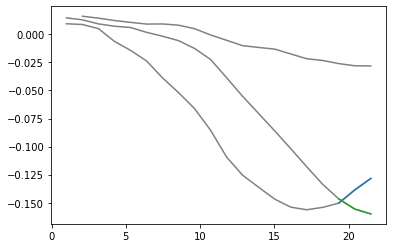

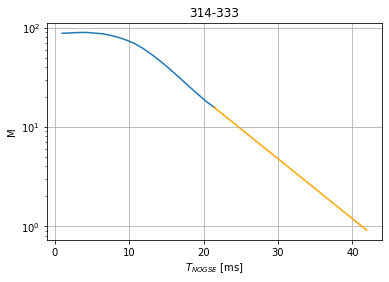

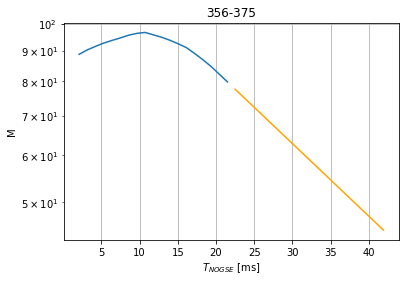

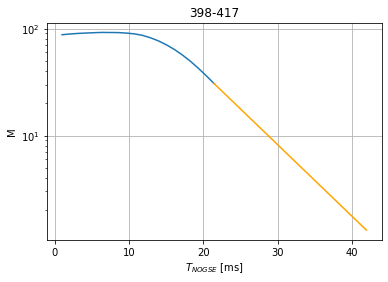

In [195]:
# necesito extrapolar las curvas para ver si el modelo anda bien ya que en lo que medimos estamos fuera de rango.

i = 0

start = 4
end = 10

derf1 = []
derf2 = []
ders = [derf1, derf2]

for it, der in zip(np.arange(2), ders):
    for serie, name in zip(np.arange(start+i,end,2), folders[start+i:end:2]):
            der.append(np.gradient(np.log(valsTensor[serie][it]),TMat[serie]))

# ploteamos la recta extrapolada en log

limsup = -17

for der, serie, folder in zip(ders[0],np.arange(start+i,end,2), folders[start+i:end:2]):
    plt.plot(TMat[serie], der, c="gray")
    plt.plot(TMat[serie][:limsup], der[:limsup])

pends = [np.mean(ders[0][0][:limsup]), np.mean(ders[0][1][:limsup]), np.mean(ders[0][2][:limsup])]

for it, serie, folder in zip(np.arange(3), np.arange(start+i,end,2), folders[start+i:end:2]):

    # calculo la ordenada de la recta
    b = np.log(valsTensor[serie][0][0]) - pends[it]*TMat[serie][0]

    fig, ax = plt.subplots()

    plt.plot(TMat[serie], valsTensor[serie][0])
    plt.plot(np.array(TMat[serie]) + TMat[serie][1], np.exp((np.array(TMat[serie]) + TMat[serie][1]) * pends[it] + b), c="orange")
    plt.title(folder)

    plt.grid()
    plt.xlabel("$T_{NOGSE}}$ [ms]")
    plt.ylabel("M")
    plt.yscale("log")

# se aca sacamos las pendientes, ahora ajustemos la expresión a las extrapolaciones y veamos que distribuciones da.

params = []

for pend, it, serie, folder in zip(pends, np.arange(3), np.arange(start+i,end,2), folders[start+i:end:2]):
    N = NMat[serie]
    G = GMat[serie]

    b = np.log(valsTensor[serie][0][0]) - pends[it]*TMat[serie][0]

    te = np.array(TMat[serie]) + TMat[serie][0]*20

    params.append(op.curve_fit(MDecCPMGdist, [N,G,te], te * pends[it] + b)[0])

In [246]:
MDecCPMGdist([np.array(TMat[serie])+TMat[serie][0]*45, np.array(N), np.array(G)],1,200,8*10**-6)

<ipython-input-155-d90831a09275>:6: RuntimeWarning: overflow encountered in exp
  return np.exp(-Dw2 * tc * (TE-(1+2*N)*tc))


array([2.64637594e-001, 2.64699224e-001, 2.64760921e-001, 2.64822686e-001,
       2.64884519e-001, 2.64946421e-001, 2.65008391e-001, 2.65070430e-001,
       2.65132537e-001, 2.65194713e-001, 7.27551122e+002, 9.22198442e+120,
       1.16934758e+239,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf])

In [224]:
np.gradient(np.log(MDecCPMG(np.array(TMat[serie])+TMat[serie][0]*3, 10*10**-6, 2, 200, 2.3*10**-12)))

array([3.35731459, 3.35731459, 3.35731459, 3.35731459, 3.35731459,
       3.35731459, 3.35731459, 3.35731459, 3.35731459, 3.35731459,
       3.35731459, 3.35731459, 3.35731459, 3.35731459, 3.35731459,
       3.35731459, 3.35731459, 3.35731459, 3.35731459, 3.35731459])